In [25]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

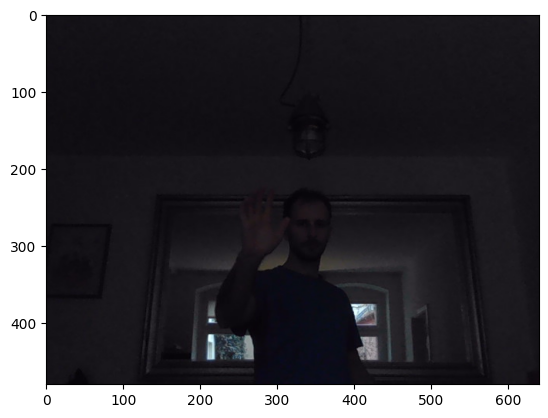

In [36]:
# Second cell - capture image
cap = cv2.VideoCapture(0)
cv2.waitKey(2000)
ret, frame = cap.read()
cap.release()
cv2.destroyAllWindows()

frame_rgb = None

if ret:
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    plt.imshow(frame_rgb)
    plt.show()
else:
    print("Failed to capture image")

(480, 640)


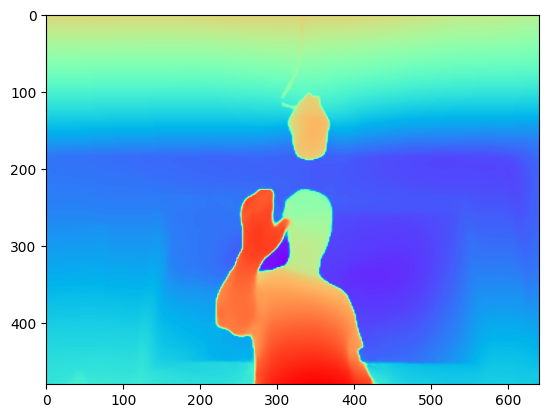

In [37]:
import sys
sys.path.append('../')
from pipeline.components.pc_generator.DepthEstimator import DepthEstimator

depth_estimator = DepthEstimator()
depth = depth_estimator.predict(frame_rgb)
print(depth.shape)
plt.imshow(depth, cmap='rainbow')

## performance evaluation

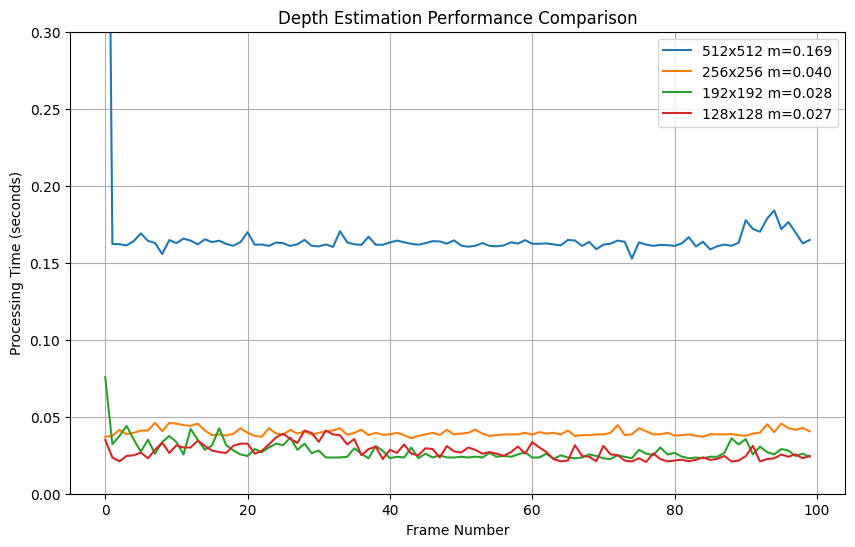

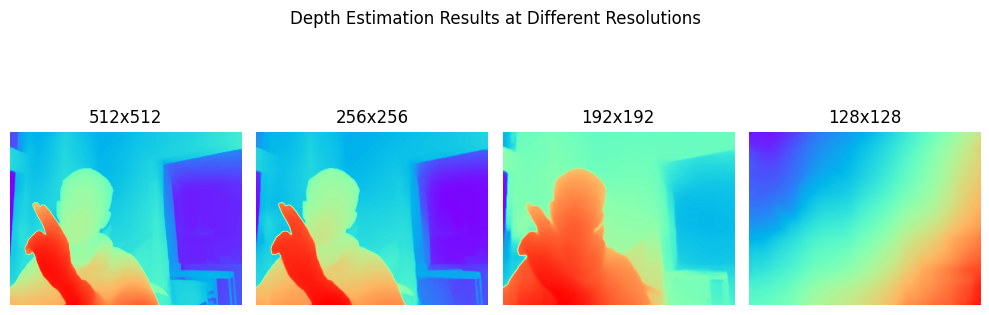

In [5]:
import time
import numpy as np

cap = cv2.VideoCapture(0)
if not cap.isOpened():
    raise Exception("Could not open webcam")


def run_depth_estimation(input_size, frames = 100):
  times = []
  example_image = None
  depth_estimator = DepthEstimator(input_size=input_size)
  for i in range(frames):
    start_time = time.time()

    ret, frame = cap.read()
    depth = depth_estimator.predict(frame_rgb)
    end_time = time.time()

    if i == frames/2:
      example_image = depth

    times.append(end_time - start_time)
                    
  cap.release()
  cv2.destroyAllWindows()

  return times, example_image

times_a, image_a = run_depth_estimation(input_size=518)
times_b, image_b = run_depth_estimation(input_size=256)
times_c, image_c = run_depth_estimation(input_size=192)
times_d, image_d = run_depth_estimation(input_size=128)

# Plot performance comparison
plt.figure(figsize=(10,6))
plt.plot(times_a, label=f'512x512 m={np.mean(times_a):.3f}')
plt.plot(times_b, label=f'256x256 m={np.mean(times_b):.3f}')
plt.plot(times_c, label=f'192x192 m={np.mean(times_c):.3f}')
plt.plot(times_d, label=f'128x128 m={np.mean(times_d):.3f}')
plt.ylim(0, 0.3)
plt.xlabel('Frame Number')
plt.ylabel('Processing Time (seconds)')
plt.title('Depth Estimation Performance Comparison')
plt.legend()
plt.grid(True)
plt.show()

# Plot depth images
fig, axes = plt.subplots(1, 4, figsize=(10,4))
fig.suptitle('Depth Estimation Results at Different Resolutions')
axes[0].imshow(image_a, cmap='rainbow')
axes[0].set_title('512x512')
axes[0].axis('off')
axes[1].imshow(image_b, cmap='rainbow') 
axes[1].set_title('256x256')
axes[1].axis('off')
axes[2].imshow(image_c, cmap='rainbow')
axes[2].set_title('192x192') 
axes[2].axis('off')
axes[3].imshow(image_d, cmap='rainbow')
axes[3].set_title('128x128') 
axes[3].axis('off')

plt.tight_layout()
plt.show()


## Image Operations
#### Trying to flatten the point cloud. Make the extremes less extreme

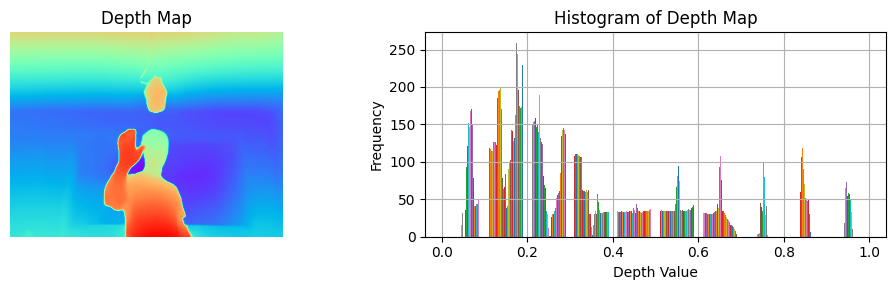

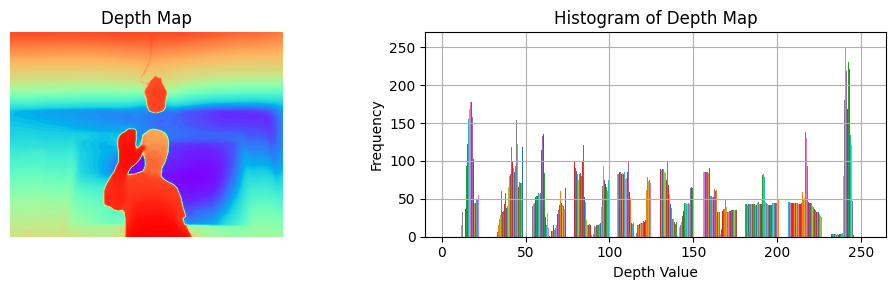

In [38]:
def print_img_and_hist(img):
  fig, axs = plt.subplots(1, 2, figsize=(10, 3))

  # Plot depth map
  axs[0].imshow(img, cmap='rainbow')
  axs[0].set_title('Depth Map')
  axs[0].axis('off')

  # Plot histogram
  axs[1].hist(img)
  axs[1].set_title('Histogram of Depth Map')
  axs[1].set_xlabel('Depth Value')
  axs[1].set_ylabel('Frequency')
  axs[1].grid(True)

  plt.tight_layout()
  plt.show()

print_img_and_hist(depth)

equalized_depth = cv2.normalize(depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
equalized_depth = cv2.equalizeHist(equalized_depth)
print_img_and_hist(equalized_depth)

#### Finding the central human contour (To test if a segmentation model is required)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [0.0..255.0].


[320, 320]


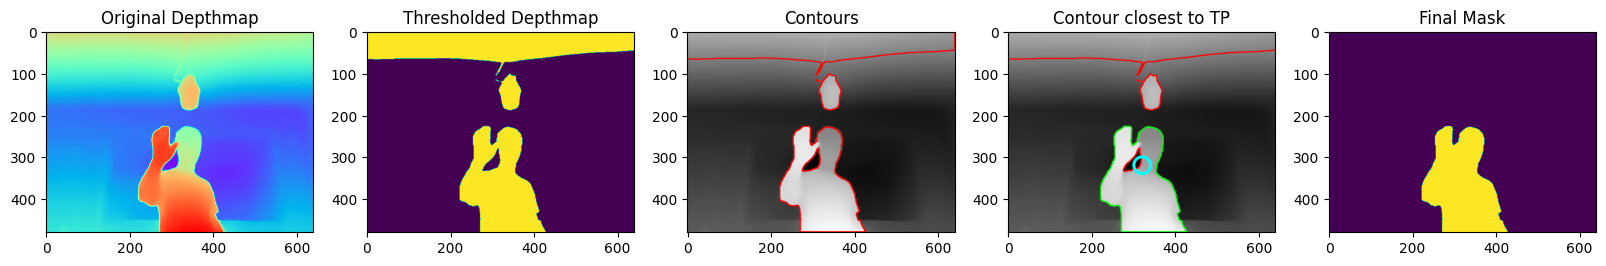

In [184]:
depth_copy = depth.copy()

fig, axs = plt.subplots(1, 5, figsize=(20, 4))
axs[0].imshow(depth_copy, cmap="rainbow")
axs[0].title.set_text("Original Depthmap")

_, mask = cv2.threshold(depth_copy, 0.5, 1, cv2.THRESH_BINARY)
mask = mask.astype(np.uint8)

axs[1].imshow(mask)
axs[1].title.set_text("Thresholded Depthmap")

contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

contour_showcase = cv2.merge([depth_copy, depth_copy, depth_copy])
cv2.drawContours(image=contour_showcase, contours=contours, contourIdx=-1, color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)
axs[2].imshow(contour_showcase)
axs[2].title.set_text("Contours")

centeroids = [np.mean(contour, axis=0) for contour in contours]

target_point = [int(mask.shape[1] / 2), int(mask.shape[0] / (3/2))]
#image_center = np.asarray(mask.shape) / 2
print(target_point)
most_central_centeroid_idx = np.argmin([np.abs(c - target_point) for c in centeroids])

cv2.drawContours(image=contour_showcase, contours=contours, contourIdx=most_central_centeroid_idx, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
cv2.circle(contour_showcase, target_point, 20, (0, 255, 255), 5)
axs[3].imshow(contour_showcase)
axs[3].title.set_text("Contour closest to TP")

final_mask = np.zeros(mask.shape)
cv2.drawContours(image=final_mask, contours=contours, contourIdx=most_central_centeroid_idx, color=(255), thickness=cv2.FILLED)
axs[4].imshow(final_mask)
axs[4].title.set_text("Final Mask")

# as a function
def get_human_mask(depth_image):
  _, mask = cv2.threshold(depth_image, 0.5, 1, cv2.THRESH_BINARY)
  mask = mask.astype(np.uint8)

  contours, hierarchy = cv2.findContours(image=mask, mode=cv2.RETR_TREE, method=cv2.CHAIN_APPROX_NONE)

  contour_showcase = cv2.merge([depth_image, depth_image, depth_image])
  cv2.drawContours(image=contour_showcase, contours=contours, contourIdx=-1, color=(255, 0, 0), thickness=2, lineType=cv2.LINE_AA)

  centeroids = [np.mean(contour, axis=0) for contour in contours]

  target_point = [int(mask.shape[1] / 2), int(mask.shape[0] / (3/2))]
  #image_center = np.asarray(mask.shape) / 2
  most_central_centeroid_idx = np.argmin([np.abs(c - target_point) for c in centeroids])

  cv2.drawContours(image=contour_showcase, contours=contours, contourIdx=most_central_centeroid_idx, color=(0, 255, 0), thickness=2, lineType=cv2.LINE_AA)
  cv2.circle(contour_showcase, target_point, 20, (0, 255, 255), 5)

  final_mask = np.zeros(mask.shape)
  print(most_central_centeroid_idx)
  cv2.drawContours(image=final_mask, contours=contours, contourIdx=most_central_centeroid_idx, color=(255), thickness=cv2.FILLED)

  return final_mask

0


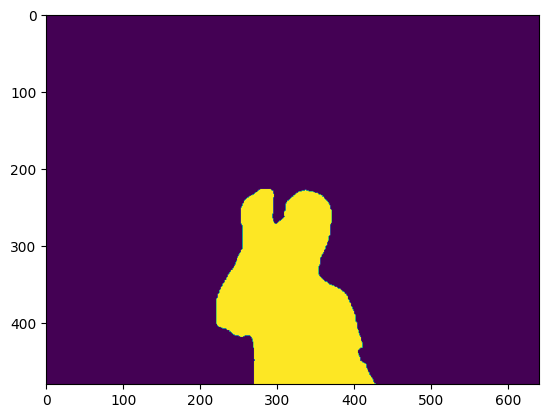

In [185]:
mask = get_human_mask(depth)
plt.imshow(mask)


## Point Cloud generation

In [180]:
import open3d as o3d
import numpy as np

def create_point_cloud(image_rgb, image_depth, depth_threshold=0.4):
    width = np.shape(image_depth)[1]
    height = np.shape(image_depth)[0]

    # Convert depth to 3D points without perspective scaling
    equalized_depth = cv2.normalize(image_depth, None, 0, 255, cv2.NORM_MINMAX).astype(np.uint8)
    equalized_depth = cv2.equalizeHist(equalized_depth)
    depth = np.asarray(equalized_depth)
    depth = depth / 255

    # Generate a 3D point grid
    u, v = np.meshgrid(np.arange(width), np.arange(height))

    # Convert to 3D coordinates
    x = u 
    y = v
    z = depth * 1000 # Maintain straight-line scaling without perspective adjustment

    # Stack and filter valid points
    human_mask = get_human_mask(image_depth)

    # Stack and filter valid points
    points = np.dstack((x, y, z)).reshape(-1, 3)
    
    #valid_points = points[depth.reshape(-1) > 0]  # Remove zero-depth points
    points_x = points[:, 0].astype(int)
    points_y = points[:, 1].astype(int)
    print(points[:, 2])
    valid_points = points[(human_mask[points_y, points_x] == 255) & (depth.reshape(-1) > depth_threshold)] # Apply Human Mask # Remove zero-depth points

    # Create an Open3D point cloud from the resulting 3D points
    pcd = o3d.geometry.PointCloud()
    pcd.points = o3d.utility.Vector3dVector(valid_points)

    # Set the colors from the RGB image
    #rgb = np.asarray(image_rgb).reshape(-1, 3) / 255.0  # Normalize to [0, 1]
    #pcd.colors = o3d.utility.Vector3dVector(rgb[depth.reshape(-1) > depth_threshold])

    # Flip the point cloud (optional, depending on the coordinate system)
    pcd.transform([[-1, 0, 0, 0],
                [0, -1, 0, 0],
                [0, 0, 1, 0],
                [0, 0, 0, 1]])

    downpcd = pcd.voxel_down_sample(voxel_size=10)

    # Visualize the point cloud
    o3d.visualization.draw_geometries([downpcd])

In [181]:
depth = depth_estimator.predict(frame_rgb)

#print(np.shape(depth))
#print(np.shape(frame_rgb))

create_point_cloud(frame_rgb, depth)

[901.96078431 898.03921569 894.11764706 ... 517.64705882 533.33333333
 549.01960784]
